# **4. Entrenamiento** **del** **modelo** **NER** **(parte 2)**

En este módulo se lleva a cabo la segunda iteración de entrenamiento del modelo NER, una vez refinados los datos de entrenamiento.

In [ ]:
!pip install -q transformers datasets seqeval accelerate

In [ ]:
from google.colab import drive
drive.mount('/content/drive')  # autoriza en el popup

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Descarga y preparación de los datos: separación del dataset en train, validation y test con la misma semilla de inicialización que en la primera fase del entrenamiento. Normalización de las etiquetas.

In [ ]:
import json
from pathlib import Path
# Leerlo de vuelta para chequear que todo esta bien
contenido = Path("train_data_2.json").read_text(encoding="utf-8")
data = json.loads(contenido)

In [ ]:
from sklearn.model_selection import train_test_split

train, rest = train_test_split(data, test_size=0.2, random_state=42)
val, test = train_test_split(rest, test_size=0.5, random_state=42)

In [ ]:
#Regularizamos las etiquetas antes de tokenizar el corpus de entrenamiento. Definimos una lista con las etiquetas ya regularizadas
import unicodedata, re

def strip_accents(s:str)->str:
    return "".join(c for c in unicodedata.normalize("NFD", s) if unicodedata.category(c) != "Mn")

def reg_label(name:str)->str:
    s = strip_accents(name).upper().strip()
    s = re.sub(r"\s+", "_", s)
    s = re.sub(r"[^A-Z0-9_]", "", s)
    return s

label_set = sorted({ reg_label(ent["label"]) for ex in train for ent in ex["entities"] })
print(label_set)

['ACEITE', 'AGUA', 'AJO', 'ARROZ', 'ATUN', 'AZUCAR', 'BACALAO', 'CALABACIN', 'CALDO', 'CEBOLLA', 'GARBANZO', 'HARINA', 'HUEVO', 'LECHE', 'LIMON', 'MANTEQUILLA', 'MERLUZA', 'NATA', 'PAN', 'PASTA', 'PATATA', 'PEREJIL', 'PIMENTON', 'PIMIENTO', 'POLLO', 'PUERRO', 'QUESO', 'SAL', 'SALMON', 'TOMATE', 'VINAGRE', 'VINO_BLANCO', 'ZANAHORIA']


In [ ]:
#A partir de las etiquetas regularizadas definimos las etiquetas BIO, así como los diccionarios que relacionan los BIO con un id numerico y vicerversa
bio_labels = ["O"] + [f"B-{l}" for l in label_set] + [f"I-{l}" for l in label_set]
label2id = {lab:i for i, lab in enumerate(bio_labels)}
id2label = {i:lab for lab,i in label2id.items()}

tokenizaciónTokenización del nuevo dataset de entrenamiento.

In [ ]:
from transformers import AutoTokenizer
model_name = "dccuchile/bert-base-spanish-wwm-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/648 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

In [ ]:
def encode_and_align(example):
    text = example["text"]
    ents = example["entities"]  # lista de dicts con start,end,label (original)

    # Regularizar labels de entidades para que coincidan con los de la lista label_set
    spans = []
    for e in ents:
        s, e2 = int(e["start"]), int(e["end"])
        if 0 <= s < e2 <= len(text):
            lab = reg_label(e["label"])
            spans.append((s, e2, lab))  # (start, end, LAB)

    # Tokenizar con offsets
    enc = tokenizer(text, return_offsets_mapping=True, truncation=True, max_length=512)
    offsets = enc["offset_mapping"]

    # Inicializar etiquetas a -100 (se ignoran en la pérdida)
    labels = [-100] * len(offsets)

    # Para cada token "real", asignar B/I si cae dentro de algún span
    for i, (start, end) in enumerate(offsets):
        if start == end:   # tokens especiales
            continue
        # encontrar entidades que contengan completamente el token (estricto)
        tag = None
        for s, e2, lab in spans:
            if start >= s and end <= e2:
                # comienzo exacto del span -> B, si no -> I
                tag = f"B-{lab}" if start == s else f"I-{lab}"
                break
        if tag is None:
            tag = "O"
        labels[i] = label2id[tag]

    enc["labels"] = labels
    return enc

In [ ]:
from datasets import Dataset, DatasetDict

ds = DatasetDict({
    "train": Dataset.from_list(train),
    "validation": Dataset.from_list(val),
    "test": Dataset.from_list(test),
})

encoded = ds.map(encode_and_align, remove_columns=ds["train"].column_names, desc="Tokenizando y alineando")

Tokenizando y alineando:   0%|          | 0/880 [00:00<?, ? examples/s]

Tokenizando y alineando:   0%|          | 0/110 [00:00<?, ? examples/s]

Tokenizando y alineando:   0%|          | 0/111 [00:00<?, ? examples/s]

Preparación de métricas de evaluación. Configuración y entrenamiento del modelo.

In [ ]:
import torch
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from seqeval.metrics import classification_report

In [ ]:
import numpy as np

def align_predictions(predictions, label_ids):
  # Obtenemos prediccionnes
  preds = np.argmax(predictions, axis=2)
  batch_size, seq_len = preds.shape
  labels_list, preds_list = [], []

  #  en cada batch de datos
  for batch_idx in range(batch_size):
    # Generamos muestras de true_values y predicciones en formato seq-eval
    example_labels, example_preds = [], []
    # Para cada documento
    for seq_idx in range(seq_len):
      # Ignoramos etiquetas que sean -100
      if label_ids[batch_idx, seq_idx] != -100:
        example_labels.append(id2label[int(label_ids[batch_idx][seq_idx])])
        example_preds.append(id2label[int(preds[batch_idx][seq_idx])])

    labels_list.append(example_labels)
    preds_list.append(example_preds)

  return preds_list, labels_list

In [ ]:
from seqeval.metrics import f1_score

def compute_metrics(eval_pred):
    y_pred, y_true = align_predictions(eval_pred.predictions,
                                       eval_pred.label_ids)
    return {"f1": f1_score(y_true,y_pred)}

In [ ]:
# Definimos algunos parámetros de configuracion
num_epochs = 5
batch_size = 16
logging_steps = 10
model_name_save = f"output-model"

In [ ]:
import random

def set_seed(seed=52):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(52)

In [ ]:
training_args = TrainingArguments(
    output_dir = model_name_save, log_level = "error",
    num_train_epochs = num_epochs,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    save_steps=50,
    weight_decay=0.01,
    disable_tqdm=False,
    logging_steps=logging_steps,
    gradient_accumulation_steps=2,
    eval_strategy="steps",
    save_strategy="steps",
    eval_steps=10,
    logging_strategy="steps",
    load_best_model_at_end=True,
    push_to_hub=False,
    report_to="none",
    seed=52,
    full_determinism=True
)

In [ ]:
from transformers import AutoConfig
model_config = AutoConfig.from_pretrained(model_name,
                                            num_labels = len(label2id),
                                            id2label = id2label,
                                            label2id=label2id)

In [ ]:
from transformers import DataCollatorForTokenClassification
data_collator = DataCollatorForTokenClassification(tokenizer,return_tensors="pt")

In [ ]:
from transformers import AutoModelForTokenClassification
def model_init():
    return AutoModelForTokenClassification.from_pretrained(
    model_name, config=model_config
)
model = AutoModelForTokenClassification.from_pretrained(model_name, config=model_config)

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer = Trainer(model = model, # model
                  args = training_args, # training_args
                  data_collator = data_collator, # data_collator
                  compute_metrics = compute_metrics, # compute_metrics
                  train_dataset = encoded["train"],
                  eval_dataset = encoded["validation"],
                  tokenizer = tokenizer)

/tmp/ipython-input-3500203268.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model = model, # model


In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,F1
10,1.230500,0.397784,0.000000
20,0.395700,0.364969,0.000000
30,0.351800,0.276763,0.000000
40,0.261600,0.228602,0.000000
50,0.230000,0.199237,0.230065
60,0.187500,0.155830,0.433962
70,0.152100,0.119214,0.557730
80,0.108700,0.097078,0.735761
90,0.088700,0.077133,0.792636
100,0.077300,0.072421,0.776427


TrainOutput(global_step=140, training_loss=0.23684899466378348, metrics={'train_runtime': 352.481, 'train_samples_per_second': 12.483, 'train_steps_per_second': 0.397, 'total_flos': 719560276858560.0, 'train_loss': 0.23684899466378348, 'epoch': 5.0})

Gráfica comparativa de la evolución de la pérdida (loss) en entrenamiento y validación a lo largo de las etapas de entrenamiento para estudiar el sobreajuste del modelo.

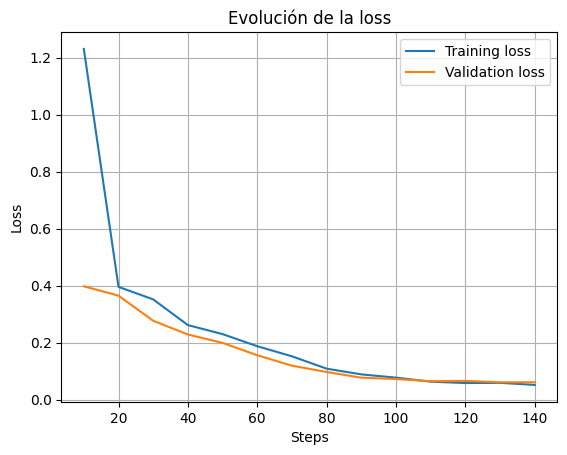

In [ ]:
# Mostrar curva de pérdida usando los logs del trainer
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(trainer.state.log_history)
# Separar las filas de entrenamiento y evaluación
train_rows = df[df["loss"].notna()].copy()
eval_rows = df[df["eval_loss"].notna()].copy()

# Fusionar por columna 'step'
combined = pd.merge(train_rows, eval_rows, on="step", suffixes=("_train", "_eval"))


# Filtramos solo los pasos con loss y eval_loss
loss_log = combined[["step", "loss_train", "eval_loss_eval"]].dropna()

plt.plot(loss_log["step"], loss_log["loss_train"], label="Training loss")
plt.plot(loss_log["step"], loss_log["eval_loss_eval"], label="Validation loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Evolución de la loss")
plt.legend()
plt.grid()
plt.show()

In [ ]:
trainer.save_model("/content/drive/MyDrive/TFM/ner_model_2")  # guarda pesos + config.json
tokenizer.save_pretrained("/content/drive/MyDrive/TFM/ner_model_2")

('/content/drive/MyDrive/TFM/ner_model_2/tokenizer_config.json',
 '/content/drive/MyDrive/TFM/ner_model_2/special_tokens_map.json',
 '/content/drive/MyDrive/TFM/ner_model_2/vocab.txt',
 '/content/drive/MyDrive/TFM/ner_model_2/added_tokens.json',
 '/content/drive/MyDrive/TFM/ner_model_2/tokenizer.json')

Evaluación del modelo

In [ ]:
path = "/content/drive/MyDrive/TFM/ner_model_2"
tokenizer = AutoTokenizer.from_pretrained(path)
model     = AutoModelForTokenClassification.from_pretrained(path)

In [ ]:
test_metrics = trainer.evaluate(encoded["test"])
print(test_metrics)

{'eval_loss': 0.0662570372223854, 'eval_f1': 0.7755102040816325, 'eval_runtime': 2.1871, 'eval_samples_per_second': 50.752, 'eval_steps_per_second': 3.201, 'epoch': 5.0}


In [ ]:
# Reporte detallado por clase (BIO) con seqeval
from seqeval.metrics import classification_report, f1_score, precision_score, recall_score
import numpy as np

# Predicciones en test
pred = trainer.predict(encoded["test"])

# OJO: tu align_predictions retorna (y_pred, y_true)
y_pred, y_true = align_predictions(pred.predictions, pred.label_ids)

# Reporte por clase (BIO)
print(classification_report(y_true, y_pred, digits=3))

# Métricas globales
print({
    "precision": precision_score(y_true, y_pred),
    "recall":    recall_score(y_true, y_pred),
    "f1":        f1_score(y_true, y_pred),
})

/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      ACEITE      0.889     0.800     0.842        50
        AGUA      0.778     0.438     0.560        16
         AJO      0.849     1.000     0.918        45
       ARROZ      1.000     1.000     1.000        15
        ATUN      0.000     0.000     0.000        11
      AZUCAR      0.769     1.000     0.870        10
     BACALAO      0.769     1.000     0.870        10
   CALABACIN      0.000     0.000     0.000         7
       CALDO      0.344     0.524     0.415        21
     CEBOLLA      0.655     1.000     0.792        38
    GARBANZO      0.545     0.600     0.571        10
      HARINA      0.739     1.000     0.850        17
       HUEVO      0.900     1.000     0.947        27
       LECHE      1.000     1.000     1.000        11
       LIMON      0.000     0.000     0.000         5
 MANTEQUILLA      0.667     1.000     0.800        10
     MERLUZA      1.000     1.000     1.000         5
        NATA      0.909    

Probamos el modelo con pipeline de agregacion, para probarlo con una receta inventada

In [ ]:
from transformers import pipeline
import torch

clf = pipeline(
    "token-classification",
    model=model,
    tokenizer=tokenizer,
    aggregation_strategy="simple",
    device=0 if torch.cuda.is_available() else -1
)

texto = """Mezcla tomate verde y cebolla troceada; añade aceite de oliva virgen extra y sal gorda. Cocina 10 minutos. """
ents = clf(texto)
# limpiar nombre de clase si viene en MAYÚSCULAS con guiones bajos
for e in ents:
    e["label"] = e.pop("entity_group")
    e["label"] = e["label"].lower().replace("_"," ")
    e["surface"] = texto[e["start"]:e["end"]]

ents  # lista de dicts con label, start, end, score, word/surface

[{'score': np.float32(0.4162101),
  'word': 'tomate',
  'start': 7,
  'end': 13,
  'label': 'tomate',
  'surface': 'tomate'},
 {'score': np.float32(0.8004093),
  'word': 'cebolla',
  'start': 22,
  'end': 29,
  'label': 'cebolla',
  'surface': 'cebolla'},
 {'score': np.float32(0.8792452),
  'word': 'aceite de oliva',
  'start': 46,
  'end': 61,
  'label': 'aceite',
  'surface': 'aceite de oliva'},
 {'score': np.float32(0.77059805),
  'word': 'sal',
  'start': 77,
  'end': 80,
  'label': 'sal',
  'surface': 'sal'}]